# 1. User Logins - Exploratory Data Analysis

### 1.1 Import the necessary modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### 1.2 Import the data

In [2]:
# use pandas' "read_json" function
logins_df = pd.read_json("logins.json")

# set the datetime column as the index
logins_df.set_index('login_time', inplace=True)

# create aggregates based on 15-min intervals
logins_df['count'] = 1
logins_df = logins_df.resample('15min').sum()
logins_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [3]:
# create a column each for the hour, minute and day of the month
logins_df['hour'] = logins_df.index.hour
logins_df['minute'] = logins_df.index.minute
logins_df['date'] = logins_df.index.day

# create a column for the 15-min groups
dict_hr = {0:'45-60',
          15:'0-15',
          30:'15-30',
          45:'30-45'}

logins_df['Quarter of the Hour'] = logins_df.minute.map(dict_hr)
logins_df.head()

,count,hour,minute,date,Quarter of the Hour
login_time,,,,,
1970-01-01 20:00:00,2,20,0,1,45-60
1970-01-01 20:15:00,6,20,15,1,0-15
1970-01-01 20:30:00,9,20,30,1,15-30
1970-01-01 20:45:00,7,20,45,1,30-45
1970-01-01 21:00:00,1,21,0,1,45-60


### 1.3 Exploratory Data Analysis

Here, we will explore whether there are any trends in the data based on the timestamp. For example, is there a particular day in the week that registers more logins. Or, is there a particular time of the day that people login more than the other times of the day? We will try to create questions and find their answers.

**1.3.1: Does the login count get affected by which day of the month it is?**

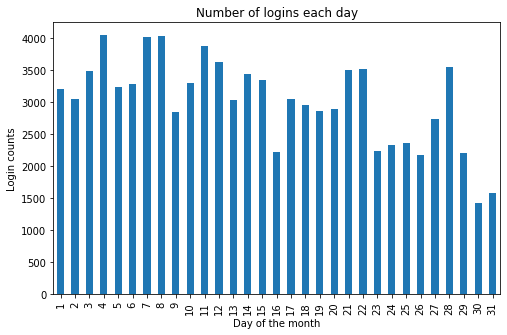

In [4]:
# Plot total login counts with respect to the day of the month
logins_df.groupby('date').sum()['count'].plot(kind='bar', figsize=(8,5))
plt.xlabel("Day of the month")
plt.ylabel("Login counts")
plt.title("Number of logins each day")
plt.show()

We find that there is **no clear indication that the day of the month affects the login rate**. There is a little trend, where on average, the login counts are lesser towards the end of the month, but they are still not so low as to consider them as outliers.

**1.3.2: Does the time of the day (hour) have an effect on whether or not people login?**

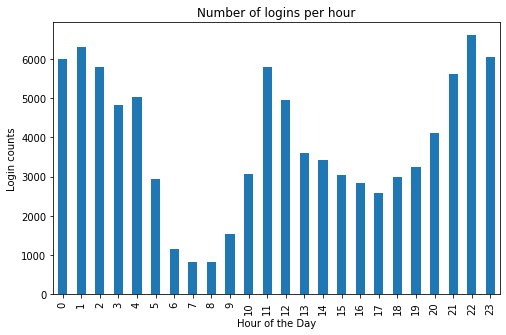

In [5]:
# plot the distribution by the hour of the day
logins_df.groupby('hour').sum()['count'].plot(kind='bar', figsize=(8,5))
plt.xlabel("Hour of the Day")
plt.ylabel("Login counts")
plt.title("Number of logins per hour")
plt.show()

It's very clear that there is a general trend in the number of logins depending on what time of the day it is. It seems that between 5am - 10am, people tend to not log in as much. May be they are resting. There is a spike close to midday, but again a drop, with a low around 5pm, after which it picks back up. The login count keeps rising into the night and stays around the same till around 5am again. This suggests that the login might be taking place in a place/store that remains open 24-hr (for example, a casino).

**1.3.3: Does the login time get affected by the time in the hour?**

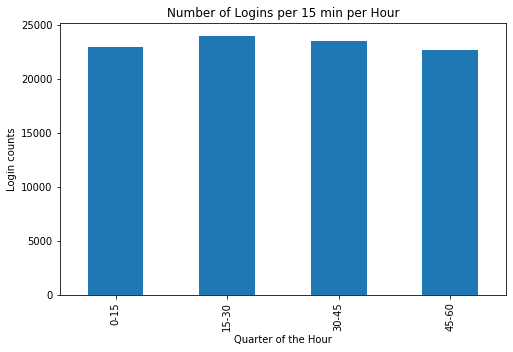

In [6]:
# plot the distribution every quarter hour
logins_df.groupby('Quarter of the Hour').sum()['count'].plot(kind='bar', figsize=(8,5))
plt.xlabel("Quarter of the Hour")
plt.ylabel("Login counts")
plt.title("Number of Logins per 15 min per Hour")
plt.show()

There is no particular trend in this case.

### 1.4 Report

This login data and the study revealed that the most demand of the place (the most logins) occur every night - after 7pm, until about 5am, after which the demand dips considerably. Thus, any marketing or promotional events, or anything of that sort needs to be scheduled to be done during those times. There are times of the day that can be ignored for such purposes (e.g., 5am in the morning).


# 2. Experimental Design

**1. Key measure of success:**
After the Ultimate managers have decided to pay for the tolls between the two cities, this should encourage the driver partners to serve both the cities. To evaluate the success of this step, the key metric to look at would be the average distance of each ride. If the average distance goes up, it would mean that there are more inter-city rides.


**2. Practical experiment:**
The practical experiment would be to set a hypothesis that the average distance is directly dependent on the reimbursement of the toll prices. In this scenario, we can do a simple hypothesis testing, with the null hypothesis being that the toll has no effect on the average distance per ride. A low p-value (<0.05) would lead us to reject the null hypothesis, thus verifying its significance. Depending on the results of the test, recommendations can be made on whether or not to take actions to subsidize toll rates for the driver partners.


# 3. Predictive Modeling

### 3.1 Importing the necessary modules

In [7]:
# data preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# model evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

### 3.2 Import the data

In [8]:
ultimate_df = pd.read_json("ultimate_data_challenge.json")
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [9]:
# display the dataset information
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


### 3.3 Feature Engineering

In [10]:
# change the data types to the required format
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

# fill the missing values with the most frequent values
for column in ['avg_rating_of_driver', 'phone', 'avg_rating_by_driver']:
    ultimate_df[column] = ultimate_df[column].fillna(ultimate_df[column].value_counts().index[0])

In [11]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [12]:
max(ultimate_df.last_trip_date)

Timestamp('2014-07-01 00:00:00')

The last date of travel recorded in the data is the 1st of July, 2014. We will set this as "today" and see if the user has taken a ride in the preceding 30 days (in the month of June). If yes, those customers will be considered as retained (1), otherwise not retained (0). We will build our model accordingly after.

In [13]:
ultimate_df['last_trip_within_30_days'] = (max(ultimate_df.last_trip_date)-ultimate_df.last_trip_date)<'30 days'
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_within_30_days
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [14]:
ultimate_df['retained'] = ultimate_df.last_trip_within_30_days.map({True:1, False:0})
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,last_trip_within_30_days,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False,0


For further analysis, the date of signup doesn't really matter, nor does the date of the last ride (trip). These columns can be discarded as they do not affect the target column - is there customer retention?

In [15]:
df = ultimate_df.drop(['signup_date','last_trip_date','last_trip_within_30_days'], axis=1)
df['ultimate_black_user'] = df['ultimate_black_user'].map({True:1, False:0})
df.head(3)

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.1,iPhone,15.4,1,46.2,3.67,5.0,1
1,Astapor,0,5.0,1.0,Android,0.0,0,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.0,iPhone,0.0,0,100.0,0.77,5.0,0


In [16]:
# take a look at the data statistics
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000
mean,2.278200,4.666282,1.074764,8.849536,0.37708,60.926084,5.796827,4.779050,0.36620
std,3.792684,0.583779,0.222336,19.958811,0.48466,37.081503,5.707357,0.445974,0.48177
min,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.00000
25%,0.000000,4.500000,1.000000,0.000000,0.00000,33.300000,2.420000,4.700000,0.00000
50%,1.000000,5.000000,1.000000,0.000000,0.00000,66.700000,3.880000,5.000000,0.00000
75%,3.000000,5.000000,1.050000,8.600000,1.00000,100.000000,6.940000,5.000000,1.00000
max,125.000000,5.000000,8.000000,100.000000,1.00000,100.000000,160.960000,5.000000,1.00000


### 3.4 Exploratory Data Analysis

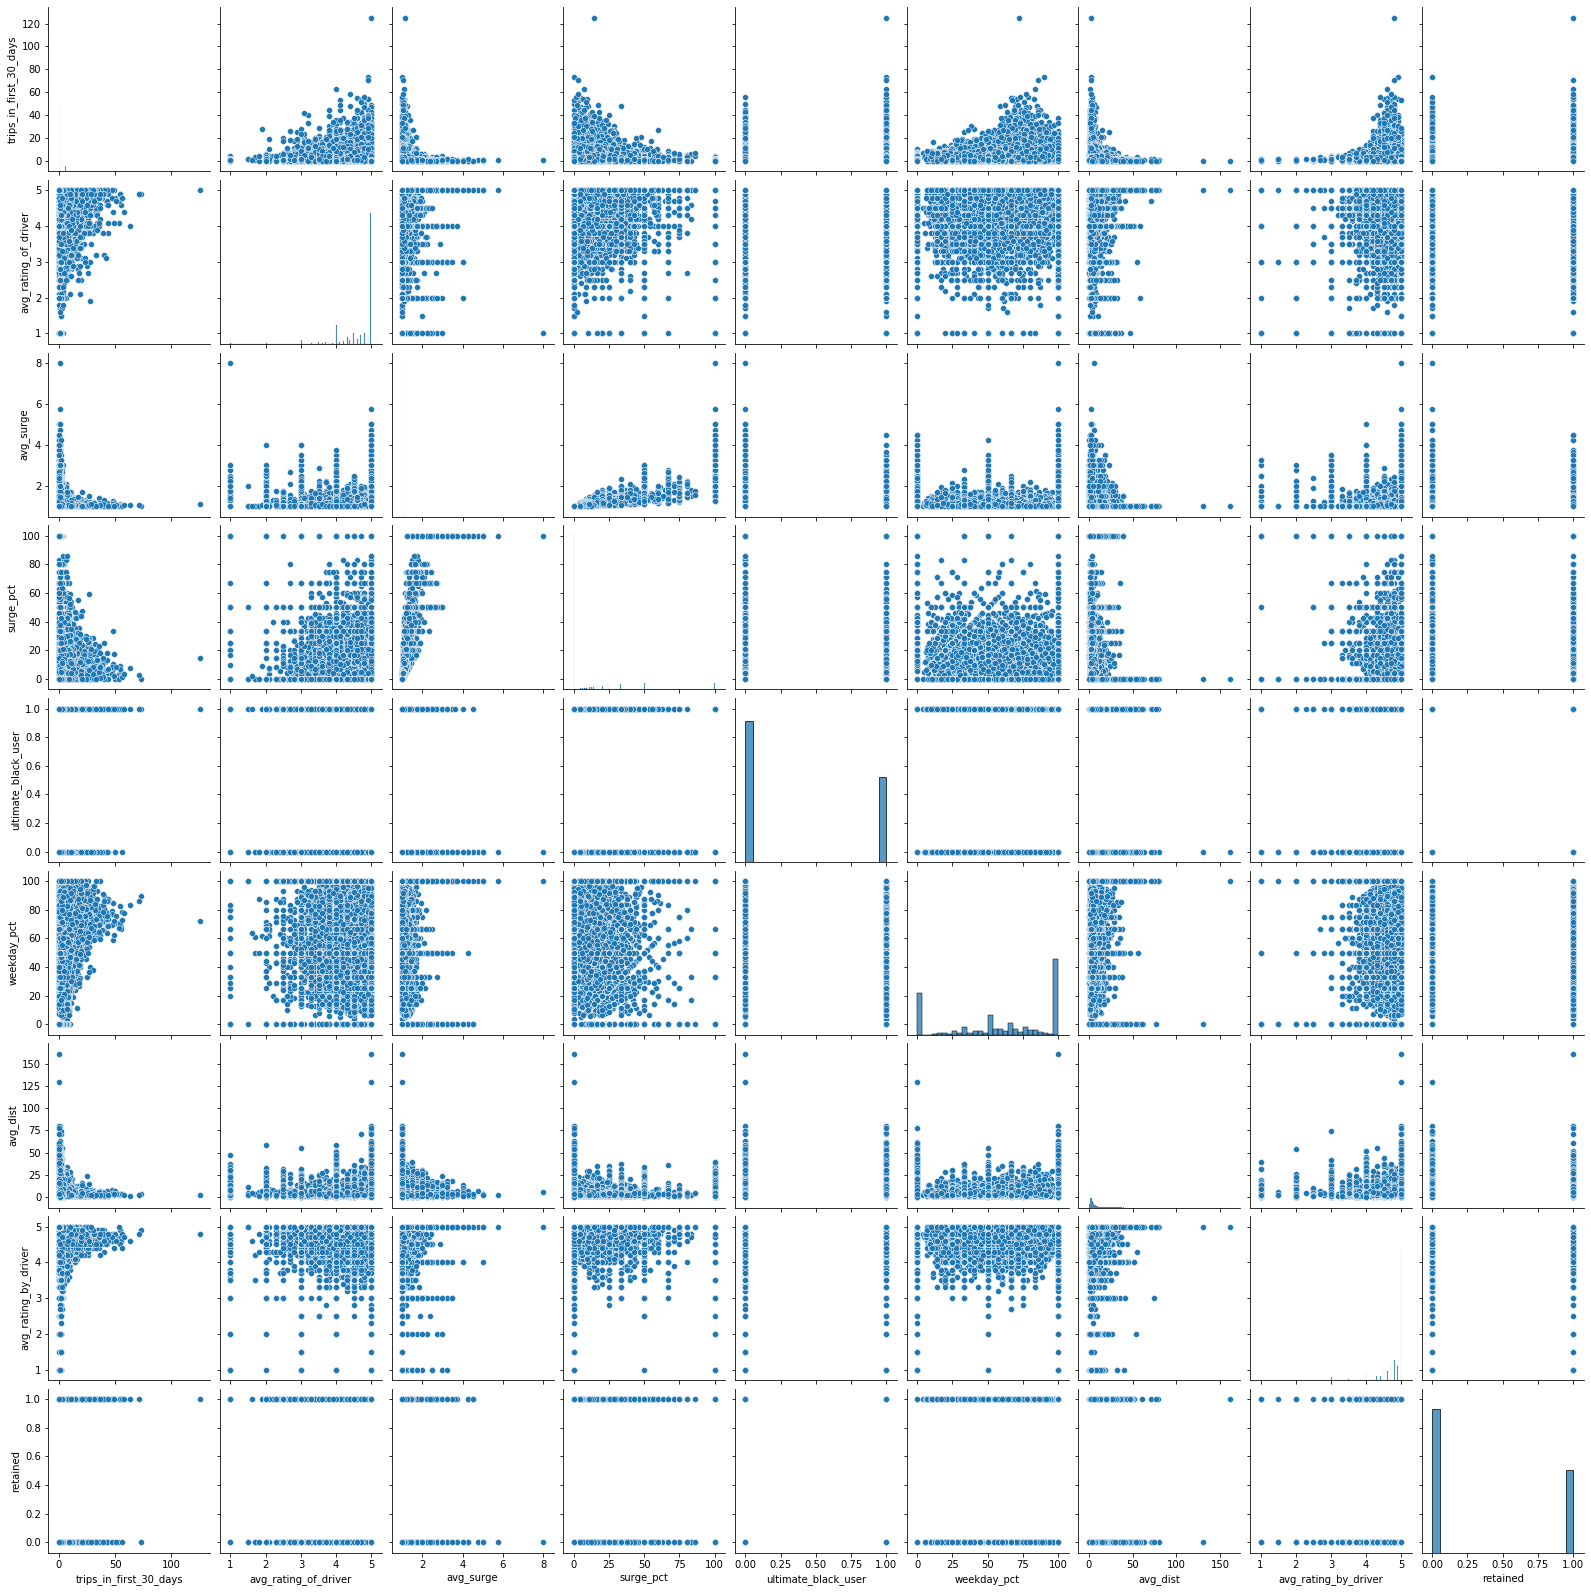

In [17]:
# look at the pairplot
# pairplot gives the distribution for each variable as well as the correlations between themselves
sns.pairplot(df)
plt.show()

No clear evidence of any type of correlation between the variables as seen in the pairplot. Let's look at the correlation heatmap. The heatmap (annotated) will give a better understanding of the correlation between the variables with each other and with the target variable. **The target variable in this case is going to be the column `retained`.**

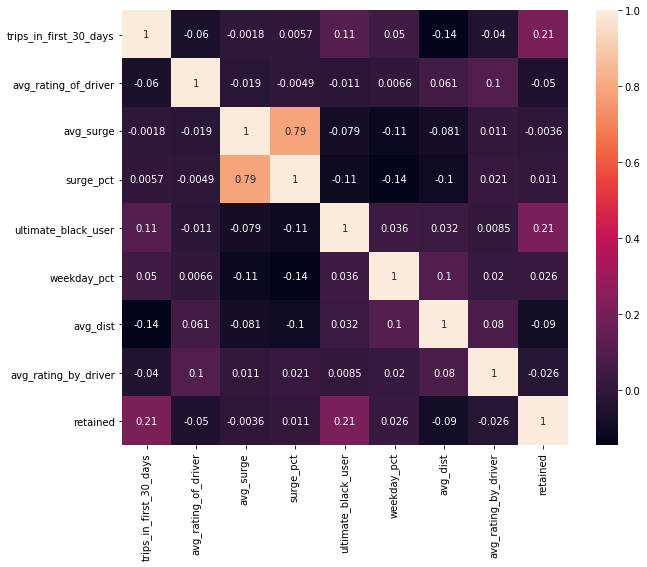

In [18]:
# plot a correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

There doesn't seem too much correlation between the variables and the target, except for the number of trips in the first 30 days and whether the user is an "ultimate black" user. Other features have little to no effect on whether or not the customer was retained.

### 3.5 Pre-processing

In [19]:
# one-hot encode the categorical columns using pandas' get_dummies() function
df = pd.get_dummies(df)
df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,1,0,1,0,0,1
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,0,1,0,0,1,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,0,1,0,0,0,1
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,1,0,1,0,0,1
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0,0,0,1,1,0


In [20]:
# split the data into X and y components
X = df.drop('retained', axis=1)
y = df.retained

In [21]:
# split into training and testing components
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# check the shape of the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((35000, 13), (15000, 13), (35000,), (15000,))

In [23]:
# scale the data columns between 0 and 1 with MinMaxScaler
scaler = MinMaxScaler((0,1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 3.6 Modeling

The problem we have at hand is that of classification. This can be solved using the regular classification models. I also plan on using a neural network as a classification tool for this problem to compare the accuracy of prediction.

**3.6.1. Logistic Regression:**

In [24]:
# Find the best parameters
param_grid_lr = {'penalty':['l1','l2','elasticnet','none'],
                'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
                'multi_class':['auto','ovr','multinomial']}

lr_cv = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5)
lr_cv.fit(X_train,y_train)

print(lr_cv.best_params_)
print(lr_cv.best_score_)

{'multi_class': 'ovr', 'penalty': 'none', 'solver': 'sag'}
0.7265142857142857


The training accuracy is:  0.7267428571428571
The testing accuracy is:  0.7236
The F1-score for the model is:  0.5692019950124688


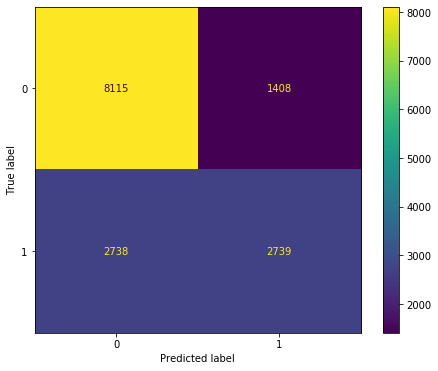

In [25]:
# using the best parameters to model
lr = LogisticRegression(penalty='none', multi_class='ovr', solver='saga', random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

lr_train_score = accuracy_score(y_train, lr.predict(X_train))
lr_test_score = accuracy_score(y_test, y_pred_lr)
lr_f1_score = f1_score(y_test, y_pred_lr)

print("The training accuracy is: ", lr_train_score)
print("The testing accuracy is: ", lr_test_score)
print("The F1-score for the model is: ", lr_f1_score)
print("===============================================")

fig, ax = plt.subplots(figsize=(8,6))
plot_confusion_matrix(lr, X_test, y_test, ax=ax)
plt.show()

The ROC-AUC score is:  0.7680197722776857


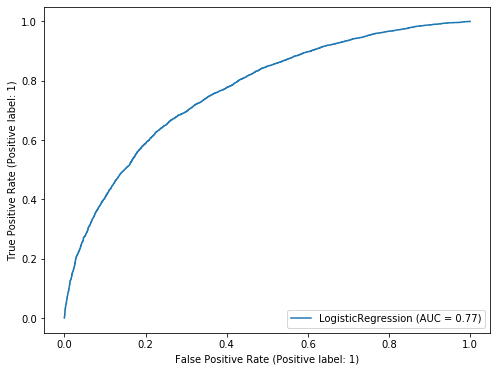

In [26]:
# ROC-AUC score and plot:
lr_y_scores = lr.predict_proba(X_test)[:,1]
lr_auroc = roc_auc_score(y_test, lr_y_scores)
print("The ROC-AUC score is: ", lr_auroc)
print("=======================================")

fig, ax = plt.subplots(figsize=(8, 6))
plot_roc_curve(lr, X_test, y_test, ax=ax)
plt.show()

**3.6.2. Decision Tree Classifier:**

In [27]:
# Find the best parameters
param_grid_dt = {'criterion':['gini','entropy'],
                'splitter':['best','random'],
                'max_depth':list(np.arange(10)),
                'min_samples_split':[2,4,6,8,10]}

dt_cv = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv=5)
dt_cv.fit(X_train,y_train)

print(dt_cv.best_params_)
print(dt_cv.best_score_)

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 6, 'splitter': 'best'}
0.7770857142857143


The training accuracy is:  0.7877428571428572
The testing accuracy is:  0.7758
The F1-score for the model is:  0.6777192141830379


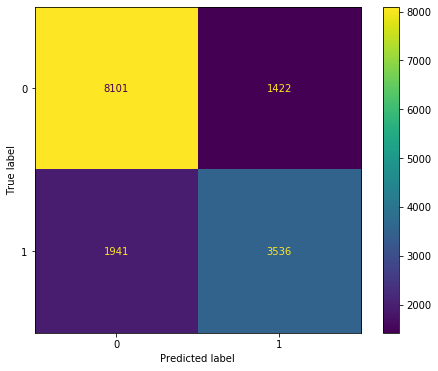

In [28]:
# using the best parameters to model
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=8, max_depth=8, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

dt_train_score = accuracy_score(y_train, dt.predict(X_train))
dt_test_score = accuracy_score(y_test, y_pred_dt)
dt_f1_score = f1_score(y_test, y_pred_dt)

print("The training accuracy is: ", dt_train_score)
print("The testing accuracy is: ", dt_test_score)
print("The F1-score for the model is: ", dt_f1_score)
print("===============================================")

fig, ax = plt.subplots(figsize=(8,6))
plot_confusion_matrix(dt, X_test, y_test, ax=ax)
plt.show()

The ROC-AUC score is:  0.8331678025569913


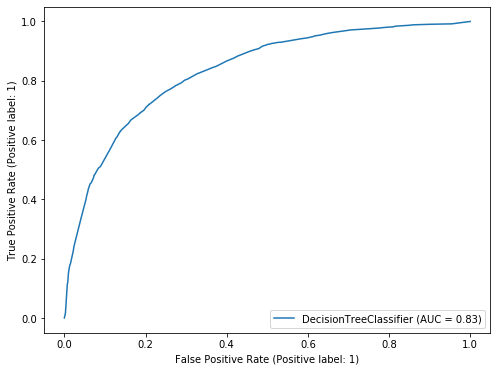

In [29]:
# ROC-AUC score and plot:
dt_y_scores = dt.predict_proba(X_test)[:,1]
dt_auroc = roc_auc_score(y_test, dt_y_scores)
print("The ROC-AUC score is: ", dt_auroc)
print("=======================================")

fig, ax = plt.subplots(figsize=(8, 6))
plot_roc_curve(dt, X_test, y_test, ax=ax)
plt.show()

**3.6.3. Support Vector Machine:**

In [30]:
# Find best parameters
param_grid_svm = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                 'gamma':['scale','auto']}
svm_cv = GridSearchCV(SVC(), param_grid_svm, cv=5)
svm_cv.fit(X_train, y_train)

print(svm_cv.best_params_)
print(svm_cv.best_score_)

{'gamma': 'scale', 'kernel': 'poly'}
0.7485142857142857


The training accuracy is:  0.7487428571428572
The testing accuracy is:  0.7432
The F1-score for the model is:  0.6368778280542986


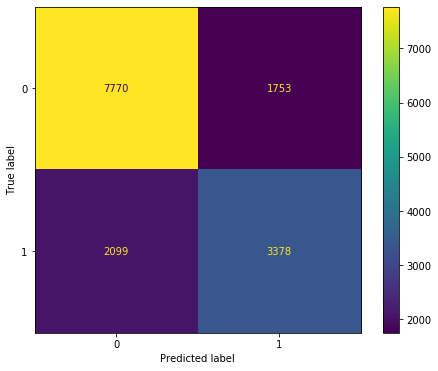

In [32]:
# the best parameters are the default ones
# set probability=True to calculate ROC-AUC later
svm = SVC(kernel='poly', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

svm_train_score = accuracy_score(y_train, svm.predict(X_train))
svm_test_score = accuracy_score(y_test, y_pred_svm)
svm_f1_score = f1_score(y_test, y_pred_svm)

print("The training accuracy is: ", svm_train_score)
print("The testing accuracy is: ", svm_test_score)
print("The F1-score for the model is: ", svm_f1_score)
print("===============================================")

fig, ax = plt.subplots(figsize=(8,6))
plot_confusion_matrix(svm, X_test, y_test, ax=ax)
plt.show()

The ROC-AUC score is:  0.7984133854956272


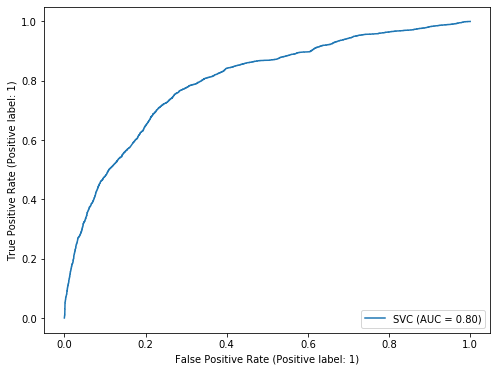

In [33]:
# ROC-AUC score and plot:
svm_y_scores = svm.predict_proba(X_test)[:,1]
svm_auroc = roc_auc_score(y_test, svm_y_scores)
print("The ROC-AUC score is: ", svm_auroc)
print("=======================================")

fig, ax = plt.subplots(figsize=(8, 6))
plot_roc_curve(svm, X_test, y_test, ax=ax)
plt.show()